In [ ]:
using PyPlot

## Plot functions

In [292]:
function draw_arrow(i::Int64, j::Int64, action::Symbol, dim::(Int64, Int64))
    NX = dim[1]
    NY = dim[2]+1
    if action == :north
        plot([i-1, i-0.5, i, i-1], [NY-j-1, NY-j, NY-j-1, NY-j-1], color="blue", lw=2)
    elseif action == :south
        plot([i-1, i-0.5, i, i-1], [NY-j, NY-j-1, NY-j, NY-j], color="blue", lw=2)
    elseif action == :east
        plot([i-1, i-1, i, i-1], [NY-j, NY-j-1, NY-j-0.5, NY-j], color="blue", lw=2)
    elseif action == :west
        plot([i, i, i-1, i], [NY-j, NY-j-1, NY-j-0.5, NY-j], color="blue", lw=2)
    end
end

function plot_data(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64})
    s = (size(V)[1], size(V)[2] .* 0.5)
    figure(figsize=s)
    subplot(121)
    xticks([])
    yticks([])
    xlim([2,size(V)[1]]-1)
    ylim([2,size(V)[2]]-1)

    for i = 1:size(V)[1]-2
        plot([i,i],[0,size(V)[2]], color="black")
    end
    for i = 1:size(V)[2]-2
        plot([0,size(V)[1]], [i,i], color="black")
    end
    
    for i = 2:size(V)[1]-1
        for j = 2:size(V)[2]-1
            draw_arrow(j, i, policy[i, j], size(V))
            #draw_arrow(j, i, :west, size(V))
        end
    end
    draw_arrow(3, 2, :west, size(V))
    subplot(122)
    imshow(V[2:end-1,2:end-1], interpolation="none")
    xticks([])
    yticks([])
end

plot_data (generic function with 2 methods)

# Convert definition to maze representation

In [ ]:
function convert_string_to_string_array(s::String)
    index = 1
    while s[index] == ' ' || s[index] == '\n'
        index = index + 1
    end
    maze = nothing
    row = []
    for i=index:length(s)
        if s[i] == '\n'
            if maze == nothing
                maze = row
            else
                maze = hcat(maze, row)
            end
            row = []
        else
            row = [row, s[i]]
        end
    end
    return maze
end



function create_experiment_setup(definition::String)
    actions = [:north, :east, :south, :west, :none]

    maze   = convert_string_to_string_array(maze_definition)
    V      = zeros(size(maze))
    policy = reshape([actions[int64(ceil(rand() * (length(actions)-1)))] for i = 1:length(maze)], (7,7))

    for i=1:length(maze)
        if maze[i] in ['#', 'T']
            V[i] = state_reward_function[maze[i]]
            policy[i] = :none
        end
    end

    return maze, policy, V
end

# Policy iteration

In [ ]:
function update_greedy_policy!(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64})
    for i = 2:size(maze)[1]-1
        for j = 2:size(maze)[2]-1
            if maze[i,j] == ' '
                possible_actions = []
                action_values = []
                if maze[i-1,j] != '#'
                    possible_actions = [possible_actions, :north]
                    action_values    = [action_values, V[i-1, j]]
                end
                if maze[i+1,j] != '#'
                    possible_actions = [possible_actions, :south]
                    action_values    = [action_values, V[i+1, j]]
                end

                if maze[i,j-1] != '#'
                    possible_actions = [possible_actions, :west]
                    action_values    = [action_values, V[i, j-1]]
                end
                if maze[i,j+1] != '#'
                    possible_actions = [possible_actions, :east]
                    action_values    = [action_values, V[i, j+1]]
                end
                best_action_value = maximum(action_values)
                possible_actions = possible_actions[findin(action_values,best_action_value)]
                action = possible_actions[int(ceil(rand() * length(possible_actions)))]
                policy[i,j] = action
            end
        end
    end
end

# Policy evaluation

In [ ]:
function update_state_value_function(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64})
    new_values = zeros(size(V))
    delta = 100.0
    while delta > 1.0
        for i=2:size(V)[1] - 1
            for j = 2:size(V)[2] - 1
                if policy[i,j] == :north
                    new_values[i,j] = V[i-1,j] - 1.0 # -1.0 for transition
                elseif policy[i,j] == :south
                    new_values[i,j] = V[i+1,j] - 1.0 # -1.0 for transition
                elseif policy[i,j] == :east
                    new_values[i,j] = V[i,j+1] - 1.0 # -1.0 for transition
                elseif policy[i,j] == :west
                    new_values[i,j] = V[i,j-1] - 1.0 # -1.0 for transition
                else
                    new_values[i,j] = V[i,j] # terminal states
                end
            end
        end
        delta = maximum(abs(new_values[2:end-1,2:end-1] .- V[2:end-1,2:end-1]))
        for i=2:size(V)[1] - 1
            for j=2:size(V)[2] - 1
                V[i,j] = new_values[i,j]
            end
        end
    end
end

# Experiment

In [289]:
maze_definition = "
#######
#T    #
#     #
#     #
#     #
#    T#
#######
"

state_reward_function = ['T' => 0.0, '#' => -100]

Dict{Char,Any} with 2 entries:
  '#' => -100
  'T' => 0.0

### Initialisation

In [290]:
maze, policy, V = create_experiment_setup(maze_definition)

(
7x7 Array{Char,2}:
 '#'  '#'  '#'  '#'  '#'  '#'  '#'
 '#'  'T'  ' '  ' '  ' '  ' '  '#'
 '#'  ' '  ' '  ' '  ' '  ' '  '#'
 '#'  ' '  ' '  ' '  ' '  ' '  '#'
 '#'  ' '  ' '  ' '  ' '  ' '  '#'
 '#'  ' '  ' '  ' '  ' '  'T'  '#'
 '#'  '#'  '#'  '#'  '#'  '#'  '#',

7x7 Array{Symbol,2}:
 :none  :none   :none   :none   :none   :none   :none
 :none  :none   :west   :north  :west   :east   :none
 :none  :east   :north  :west   :south  :east   :none
 :none  :east   :east   :west   :south  :east   :none
 :none  :south  :east   :north  :west   :north  :none
 :none  :east   :north  :west   :west   :none   :none
 :none  :none   :none   :none   :none   :none   :none,

7x7 Array{Float64,2}:
 -100.0  -100.0  -100.0  -100.0  -100.0  -100.0  -100.0
 -100.0     0.0     0.0     0.0     0.0     0.0  -100.0
 -100.0     0.0     0.0     0.0     0.0     0.0  -100.0
 -100.0     0.0     0.0     0.0     0.0     0.0  -100.0
 -100.0     0.0     0.0     0.0     0.0     0.0  -100.0
 -100.0     0.0     0.0     0

### Policy iteration 1

[-100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0
 -100.0 0.0 0.0 0.0 0.0 0.0 -100.0
 -100.0 0.0 0.0 0.0 0.0 0.0 -100.0
 -100.0 0.0 0.0 0.0 0.0 0.0 -100.0
 -100.0 0.0 0.0 0.0 0.0 0.0 -100.0
 -100.0 0.0 0.0 0.0 0.0 0.0 -100.0
 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0]
[:none :none :none :none :none :none :none
 :none :none :west :south :west :south :none
 :none :north :north :south :east :west :none
 :none :east :south :north :south :south :none
 :none :east :west :south :south :north :none
 :none :east :north :north :west :none :none
 :none :none :none :none :none :none :none]


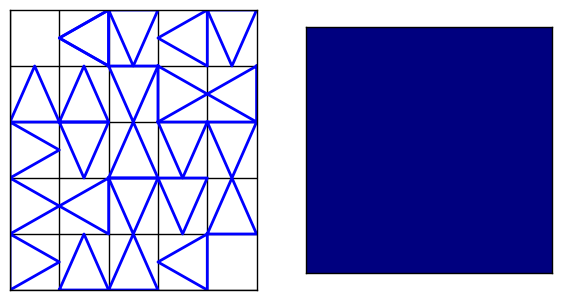

In [298]:
update_greedy_policy!(maze, policy, V)
plot_data(maze, policy, V)
println(V)
println(policy)

### Policy evaluation 1

[-100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0
 -100.0 0.0 -1.0 -1.0 -1.0 -1.0 -100.0
 -100.0 -1.0 -1.0 -1.0 -1.0 -1.0 -100.0
 -100.0 -1.0 -1.0 -1.0 -1.0 -1.0 -100.0
 -100.0 -1.0 -1.0 -1.0 -1.0 -1.0 -100.0
 -100.0 -1.0 -1.0 -1.0 -1.0 0.0 -100.0
 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0]
[:none :none :none :none :none :none :none
 :none :none :west :south :west :south :none
 :none :north :north :south :east :west :none
 :none :east :south :north :south :south :none
 :none :east :west :south :south :north :none
 :none :east :north :north :west :none :none
 :none :none :none :none :none :none :none]


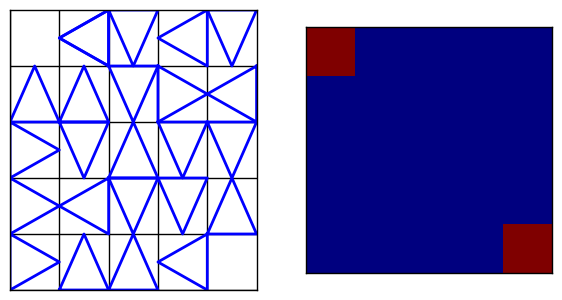

In [299]:
update_state_value_function(maze, policy, V)
plot_data(maze, policy, V)
println(V)
println(policy)

[-100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0
 -100.0 0.0 -1.0 -1.0 -1.0 -1.0 -100.0
 -100.0 -1.0 -1.0 -1.0 -1.0 -1.0 -100.0
 -100.0 -1.0 -1.0 -1.0 -1.0 -1.0 -100.0
 -100.0 -1.0 -1.0 -1.0 -1.0 -1.0 -100.0
 -100.0 -1.0 -1.0 -1.0 -1.0 0.0 -100.0
 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0]
[:none :none :none :none :none :none :none
 :none :none :west :west :west :south :none
 :none :north :west :east :west :south :none
 :none :north :north :north :south :north :none
 :none :east :north :south :north :south :none
 :none :north :west :north :east :none :none
 :none :none :none :none :none :none :none]


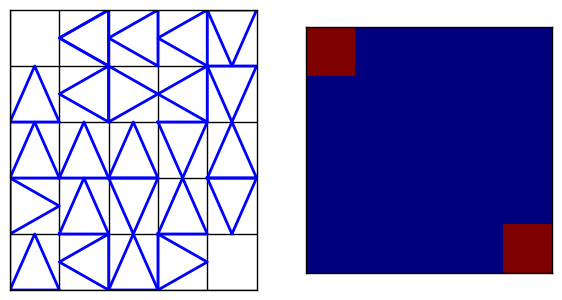

In [300]:
update_greedy_policy!(maze, policy, V)
plot_data(maze, policy, V)
println(V)
println(policy)

[-100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0
 -100.0 0.0 -1.0 -2.0 -2.0 -2.0 -100.0
 -100.0 -1.0 -2.0 -2.0 -2.0 -2.0 -100.0
 -100.0 -2.0 -2.0 -2.0 -2.0 -2.0 -100.0
 -100.0 -2.0 -2.0 -2.0 -2.0 -1.0 -100.0
 -100.0 -2.0 -2.0 -2.0 -1.0 0.0 -100.0
 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0]
[:none :none :none :none :none :none :none
 :none :none :west :west :west :south :none
 :none :north :west :east :west :south :none
 :none :north :north :north :south :north :none
 :none :east :north :south :north :south :none
 :none :north :west :north :east :none :none
 :none :none :none :none :none :none :none]


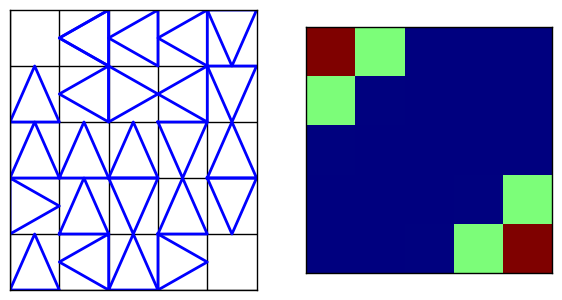

In [301]:
update_state_value_function(maze, policy, V)
plot_data(maze, policy, V)
println(V)
println(policy)

[-100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0
 -100.0 0.0 -1.0 -2.0 -2.0 -2.0 -100.0
 -100.0 -1.0 -2.0 -2.0 -2.0 -2.0 -100.0
 -100.0 -2.0 -2.0 -2.0 -2.0 -2.0 -100.0
 -100.0 -2.0 -2.0 -2.0 -2.0 -1.0 -100.0
 -100.0 -2.0 -2.0 -2.0 -1.0 0.0 -100.0
 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0]
[:none :none :none :none :none :none :none
 :none :none :west :west :west :south :none
 :none :north :west :west :east :south :none
 :none :north :south :west :south :south :none
 :none :south :east :north :south :south :none
 :none :east :west :east :east :none :none
 :none :none :none :none :none :none :none]


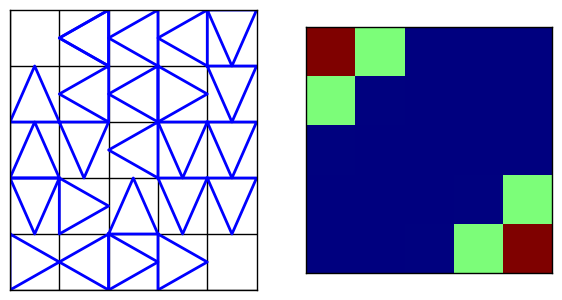

In [302]:
update_greedy_policy!(maze, policy, V)
plot_data(maze, policy, V)
println(V)
println(policy)

[-100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0
 -100.0 0.0 -1.0 -2.0 -3.0 -3.0 -100.0
 -100.0 -1.0 -2.0 -3.0 -3.0 -3.0 -100.0
 -100.0 -2.0 -3.0 -3.0 -3.0 -2.0 -100.0
 -100.0 -3.0 -3.0 -3.0 -2.0 -1.0 -100.0
 -100.0 -3.0 -3.0 -2.0 -1.0 0.0 -100.0
 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0]
[:none :none :none :none :none :none :none
 :none :none :west :west :west :south :none
 :none :north :west :west :east :south :none
 :none :north :south :west :south :south :none
 :none :south :east :north :south :south :none
 :none :east :west :east :east :none :none
 :none :none :none :none :none :none :none]


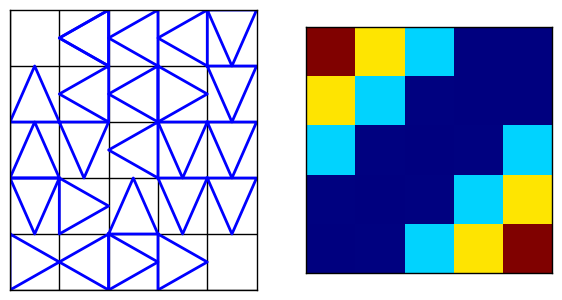

In [303]:
update_state_value_function(maze, policy, V)
plot_data(maze, policy, V)
println(V)
println(policy)

[-100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0
 -100.0 0.0 -1.0 -2.0 -3.0 -3.0 -100.0
 -100.0 -1.0 -2.0 -3.0 -3.0 -3.0 -100.0
 -100.0 -2.0 -3.0 -3.0 -3.0 -2.0 -100.0
 -100.0 -3.0 -3.0 -3.0 -2.0 -1.0 -100.0
 -100.0 -3.0 -3.0 -2.0 -1.0 0.0 -100.0
 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0]
[:none :none :none :none :none :none :none
 :none :none :west :west :west :west :none
 :none :north :west :west :east :south :none
 :none :north :north :west :south :south :none
 :none :north :east :east :south :south :none
 :none :north :east :east :east :none :none
 :none :none :none :none :none :none :none]


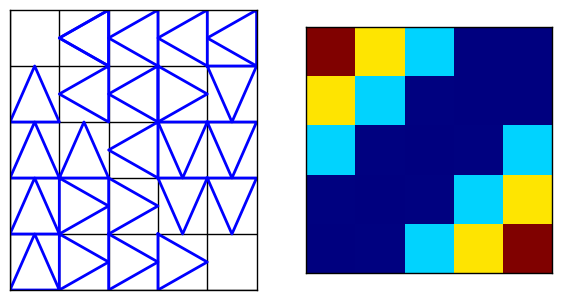

In [304]:
update_greedy_policy!(maze, policy, V)
plot_data(maze, policy, V)
println(V)
println(policy)

[-100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0
 -100.0 0.0 -1.0 -2.0 -3.0 -4.0 -100.0
 -100.0 -1.0 -2.0 -3.0 -4.0 -3.0 -100.0
 -100.0 -2.0 -3.0 -4.0 -3.0 -2.0 -100.0
 -100.0 -3.0 -4.0 -3.0 -2.0 -1.0 -100.0
 -100.0 -4.0 -3.0 -2.0 -1.0 0.0 -100.0
 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0]
[:none :none :none :none :none :none :none
 :none :none :west :west :west :west :none
 :none :north :west :west :east :south :none
 :none :north :north :west :south :south :none
 :none :north :east :east :south :south :none
 :none :north :east :east :east :none :none
 :none :none :none :none :none :none :none]


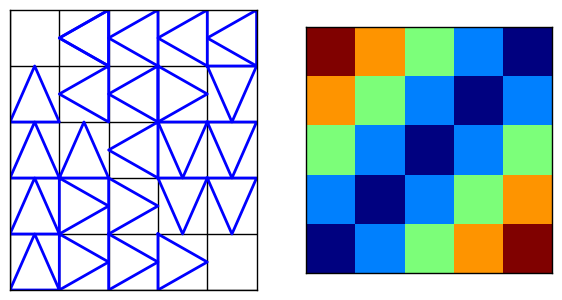

In [305]:
update_state_value_function(maze, policy, V)
plot_data(maze, policy, V)
println(V)
println(policy)

[-100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0
 -100.0 0.0 -1.0 -2.0 -3.0 -4.0 -100.0
 -100.0 -1.0 -2.0 -3.0 -4.0 -3.0 -100.0
 -100.0 -2.0 -3.0 -4.0 -3.0 -2.0 -100.0
 -100.0 -3.0 -4.0 -3.0 -2.0 -1.0 -100.0
 -100.0 -4.0 -3.0 -2.0 -1.0 0.0 -100.0
 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0]
[:none :none :none :none :none :none :none
 :none :none :west :west :west :south :none
 :none :north :north :west :west :south :none
 :none :north :north :east :south :south :none
 :none :north :west :east :east :south :none
 :none :east :east :east :east :none :none
 :none :none :none :none :none :none :none]


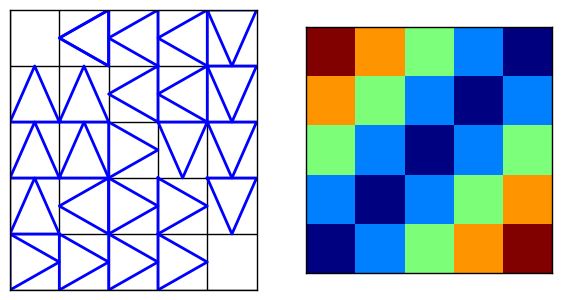

In [306]:
update_greedy_policy!(maze, policy, V)
plot_data(maze, policy, V)
println(V)
println(policy)

[-100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0
 -100.0 0.0 -1.0 -2.0 -3.0 -4.0 -100.0
 -100.0 -1.0 -2.0 -3.0 -4.0 -3.0 -100.0
 -100.0 -2.0 -3.0 -4.0 -3.0 -2.0 -100.0
 -100.0 -3.0 -4.0 -3.0 -2.0 -1.0 -100.0
 -100.0 -4.0 -3.0 -2.0 -1.0 0.0 -100.0
 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0 -100.0]
[:none :none :none :none :none :none :none
 :none :none :west :west :west :south :none
 :none :north :north :west :west :south :none
 :none :north :north :east :south :south :none
 :none :north :west :east :east :south :none
 :none :east :east :east :east :none :none
 :none :none :none :none :none :none :none]


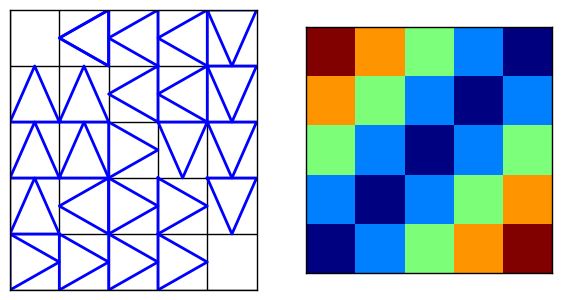

In [307]:
update_state_value_function(maze, policy, V)
plot_data(maze, policy, V)
println(V)
println(policy)